# Implementing the U-Net Architecture
The paper uses a U-Net architecture for doing the image inpainting. We've implemented this in `libs/unet.py` module, and we will review it here.

In [1]:
import sys
sys.path.append("../libs/")

In [2]:
import gc
from copy import deepcopy
import cv2
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

import matplotlib
import matplotlib.pyplot as plt

from util import random_mask

%matplotlib inline

# Settings
MAX_BATCH_SIZE = 128

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
from unet import PConvUnet
    
PConvUnet().summary()

>> Now creating Partial Conv U-Net Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_1 (PConv2D)            [(None, 256, 256, 64 9472        input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           p_c

# Testing out on single image

Shape of image is: (512, 512, 3)


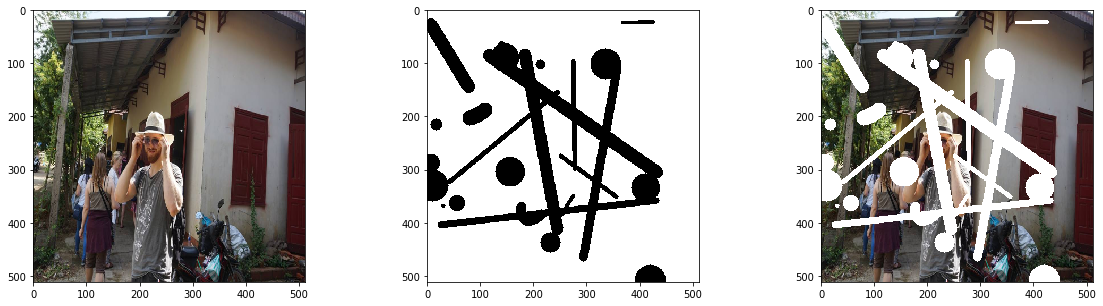

In [4]:
# Load image
img = cv2.imread('../data/sample_image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512)) / 255
shape = img.shape
print(f"Shape of image is: {shape}")

# Load mask
mask = random_mask(shape[0], shape[1])

# Image + mask
masked_img = deepcopy(img)
masked_img[mask==0] = 1

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

## Creating data generator
In this simple testing case we'll only be testing the architecture on a single image to see how it performs. We create a generator that will infinitely yield the same image and masked_image for us. The generator is based off the ImageDataGenerator from keras.processing, which allows us to do all kinds of autmentation more easily. 

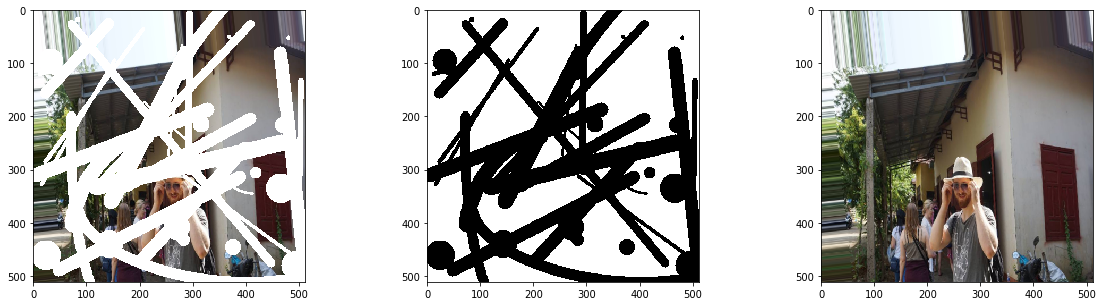

In [5]:
class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            ori = next(super().flow(x, *args, **kwargs))

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori        

# Create datagen
datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create generator from numpy arrays
batch = np.stack([img for _ in range(MAX_BATCH_SIZE)], axis=0)
generator = datagen.flow(x=batch, batch_size=4)

# Get samples & Display them
(masked, mask), ori = next(generator)

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(masked[0,:,:,:])
axes[1].imshow(mask[0,:,:,:]*255)
axes[2].imshow(ori[0,:,:,:])

## Training classifier on single image

In [ ]:
model = PConvUnet()
model.fit(
    generator, 
    steps_per_epoch=5000,
    epochs=10,    
    test_imgs=[next(generator)],
    workers=2
)

>> Now creating Partial Conv U-Net Model
>> Fitting epoch 1
Epoch 1/1
 594/5000 [==>...........................] - ETA: 41:22 - loss: 1537704.2047

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\tensorflow18\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-0e9f1a03b667>", line 7, in <module>
    workers=2
  File "../libs\unet.py", line 176, in fit
    *args, **kwargs
  File "C:\ProgramData\Anaconda3\envs\tensorflow18\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow18\lib\site-packages\keras\engine\training.py", line 1426, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\ProgramData\Anaconda3\envs\tensorflow18\lib\site-packages\keras\engine\training_generator.py", line 191, in fit_generator
    class_weight=class_weight)
  File "C:\ProgramData\Anaconda3\envs\tensorflow18\lib\site-packages\keras\engine\training.py", line 1220, in train_on_batch
    outputs = self.train_function(ins)
  File "C:

KeyboardInterrupt: 

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\tensorflow18\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow18\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow18\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\envs\tensorflow18\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\envs\tensorflow18\lib\site-packages\ipykernel\kernelbase.py", line 421, in execute_request
    self._abort_queues()
  File "C:\ProgramData\Anaconda3\envs\tensorflow18\lib\site-packages\ipykernel\kernelbase.py", line 636, in _abort_queues
    